In [ ]:
import httpimport
# imports latest code from the main branch of our github repo
with httpimport.github_repo(username='NeilFranks', repo='Battleship-AI', branch='main', module=['utils', 'bs_gym_agents', 'bs_gym_env', 'canon_obs', 'DQN_canon']):
  import utils
  import bs_gym_agents
  import bs_gym_env
  import canon_obs
  import DQN_canon

import pandas as pd
import time
import tqdm
import statistics
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this cells loads trained models from a google drive folder

params = DQN_canon.DEFAULT_PARAMS.copy()
hidden_size = DQN_canon.HIDDEN_SIZE

q_agents = dict()

for board_size in range(5, 11):
  q_func = DQN_canon.Q_function_CNN(board_size, hidden_size)
  q_agent = DQN_canon.Q_learning_agent(q_function=q_func, params=params, board_dimension=board_size)
  q_agent.load_agent('/content/drive/MyDrive/574_models/three by three/{0}x{0}_hidden512_episodes10000_model.pt'.format(board_size))
  q_agent.q_function = q_agent.q_function.cuda()
  q_agents[board_size] = q_agent

c_q_agents = dict()

for board_size in range(5, 11):
  q_func = DQN_canon.Q_function_CNN(board_size, hidden_size)
  q_agent = DQN_canon.Q_learning_agent(q_function=q_func, params=params, board_dimension=board_size)
  q_agent.load_agent('/content/drive/MyDrive/574_models/three by three/{0}x{0}_hidden512_episodes10000_canon_model.pt'.format(board_size))
  q_agent.q_function = q_agent.q_function.cuda()
  c_q_agents[board_size] = q_agent

https://raw.githubusercontent.com/NeilFranks/Battleship-AI/main//DQN_canon.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# this cell evaluates all the agent's against one another on board sizes ranging from 5x5 to 10x10
# using 3 ships of length 3.

#ships = utils.DEFAULT_SHIPS
ships = {3:3}

agents = {
  'Random': bs_gym_agents.RandomBattleshipAgent(),
  'Preferred': bs_gym_agents.HardCodedBattleshipAgent(),
  'Probabilistic': bs_gym_agents.ProbabilisticAgent(ships=ships),
}

results = pd.DataFrame(columns=['min', 'median', 'max', 'mean', 'std', 'avg_time', 'episodes', 'grid_size'])
episodes = 100

for grid_size in range(5, 11):
  print('\nevaluating agents of grid of size {}'.format(grid_size))
  env = bs_gym_env.BattleshipEnv(width=grid_size, height=grid_size, ships=ships)
  agents['Deep-Q'] = q_agents[grid_size]
  agents['Canon-Deep-Q'] = c_q_agents[grid_size]
  agents['PFilter'] = bs_gym_agents.POMDPAgent(ships=ships, board_width=grid_size, board_height=grid_size)
  canon = canon_obs.Canonicalizer(grid_size=grid_size)
  for name, agent in agents.items():
    shots_fired_totals = []
    start = time.time()
    for _ in tqdm.tqdm(range(episodes), desc='Evaluating {} agent'.format(name), position=0, leave=True):
      agent.reset()
      obs = env.reset()#favor_top=100, favor_left=100, gradient_coef=lambda x: x**10)
      done = False
      shots_fired = 0
      while not done:
        if name == 'Canon-Deep-Q':
          c_obs, c_tuple = canon.canon_obs(obs, return_tuple=True)
          c_action = agent.select_action(c_obs, test=True)
          action = canon.uncanon_action(c_action, c_tuple)
        else:
          if name == 'Deep-Q':
            action = agent.select_action(obs, test=True)
          else:
            action = agent.select_action(obs)
        obs, _, done, info = env.step(action)
        shots_fired += 1
      shots_fired_totals.append(shots_fired)
    #compute statistics
    avg_time = (time.time() - start) / episodes
    min_sf = min(shots_fired_totals)
    max_sf = max(shots_fired_totals)
    median_sf = statistics.median(shots_fired_totals)
    mean_sf = statistics.mean(shots_fired_totals)
    std_sf = statistics.stdev(shots_fired_totals)
    agent_results = pd.Series(data={'min':min_sf, 'median':median_sf, 
                                    'max':max_sf, 'mean':mean_sf, 
                                    'std':std_sf, 'avg_time':avg_time,
                                    'episodes':episodes, 'grid_size': grid_size},
                                    name=name)
    results = results.append(agent_results)
print(results)

Evaluating Random agent:  44%|████▍     | 44/100 [00:00<00:00, 432.53it/s]


evaluating agents of grid of size 5


Evaluating Random agent:  26%|██▌       | 26/100 [00:00<00:00, 256.10it/s]


evaluating agents of grid of size 6


Evaluating Random agent:   0%|          | 0/100 [00:00<?, ?it/s]


evaluating agents of grid of size 7


Evaluating Random agent:  11%|█         | 11/100 [00:00<00:00, 109.20it/s]


evaluating agents of grid of size 8


Evaluating Random agent:   7%|▋         | 7/100 [00:00<00:01, 65.22it/s]


evaluating agents of grid of size 9


Evaluating Random agent:   0%|          | 0/100 [00:00<?, ?it/s]


evaluating agents of grid of size 10


Evaluating PFilter agent: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

                min  median    max  ...  avg_time  episodes  grid_size
Random         18.0    24.0   25.0  ...  0.002581     100.0        5.0
Preferred      11.0    16.0   23.0  ...  0.001862     100.0        5.0
Probabilistic   9.0    14.0   17.0  ...  0.004913     100.0        5.0
Deep-Q         18.0    24.0   25.0  ...  0.017683     100.0        5.0
Canon-Deep-Q   16.0    23.0   25.0  ...  0.021523     100.0        5.0
PFilter        10.0    14.0   17.0  ...  0.243041     100.0        5.0
Random         25.0    34.0   36.0  ...  0.003755     100.0        6.0
Preferred      11.0    21.0   32.0  ...  0.002374     100.0        6.0
Probabilistic  11.0    17.0   21.0  ...  0.010081     100.0        6.0
Deep-Q         21.0    33.5   36.0  ...  0.025105     100.0        6.0
Canon-Deep-Q   16.0    33.0   36.0  ...  0.031250     100.0        6.0
PFilter        11.0    17.0   21.0  ...  0.373662     100.0        6.0
Random         29.0    47.0   49.0  ...  0.006102     100.0        7.0
Prefer

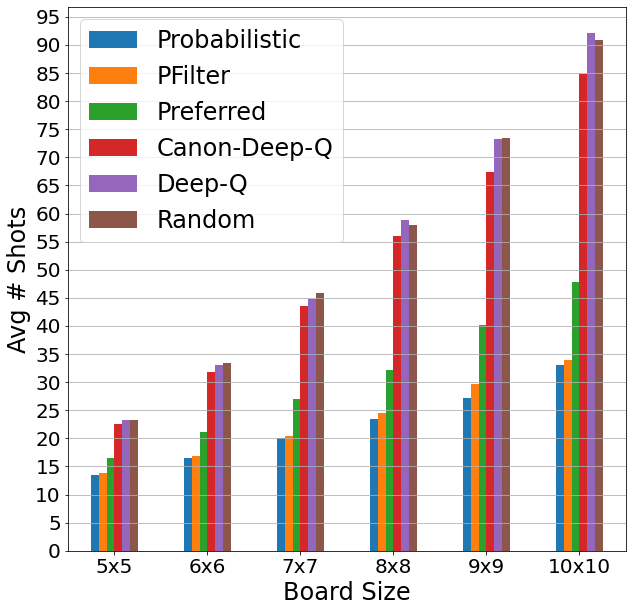

In [ ]:
# this cell creates a bar graph comparing the results from the previous cell

data = {'Probabilistic': [], 'PFilter': [], 'Preferred': [], 'Canon-Deep-Q': [], 'Deep-Q': [], 'Random': []}

for name, row in results[['mean' ,'grid_size']].iterrows():
  data[name].append(row['mean'])



idx = ['{0}x{0}'.format(board_size) for board_size in range(5,11)]
df = pd.DataFrame(data, index=idx)

axis = df.plot.bar(figsize=(10,10),
            xlabel='Board Size', ylabel='Avg # Shots', fontsize=20, rot=0, yticks=[i*5 for i in range(20)])

axis.grid(axis='y')
axis.legend(fontsize=24)
axis.xaxis.label.set_size(24)
axis.yaxis.label.set_size(24)


In [ ]:
# comparison of training rate between canon and non canon deep q

canon_file_data = {}
non_canon_file_data = {}

for board_size in range(5,11):
  with open('/content/drive/MyDrive/574_models/three by three/{0}x{0}_hidden512_canon_log.json'.format(board_size)) as file:
    canon_file_data[board_size] = eval(file.read())
  with open('/content/drive/MyDrive/574_models/three by three/{0}x{0}_hidden512_log.json'.format(board_size)) as file:
    non_canon_file_data[board_size] = eval(file.read())

print(canon_file_data[5])

{'reward_hist': [13.637000000000002, 13.662000000000004, 13.695, 13.726999999999999, 13.776000000000003, 13.738000000000001, 13.719000000000003, 13.714, 13.711999999999998, 13.680000000000001, 13.725, 13.695000000000002, 13.68, 13.738000000000005, 13.743000000000002, 13.703, 13.730000000000002, 13.717, 13.711000000000002, 13.708000000000004, 13.655000000000003, 13.650000000000002, 13.626000000000003, 13.663000000000004, 13.674000000000001, 13.669000000000006, 13.660000000000004, 13.661, 13.661000000000007, 13.679, 13.718000000000002, 13.653000000000002, 13.665, 13.718, 13.663000000000002, 13.658, 13.667, 13.677000000000003, 13.655999999999999, 13.668000000000005, 13.680000000000001, 13.671, 13.678000000000004, 13.644000000000004, 13.653000000000002, 13.651000000000003, 13.709000000000003, 13.730000000000002, 13.648000000000003, 13.734000000000004, 13.763, 13.655000000000003, 13.738999999999999, 13.771, 13.722000000000001, 13.727000000000002, 13.808000000000003, 13.781, 13.7070000000000

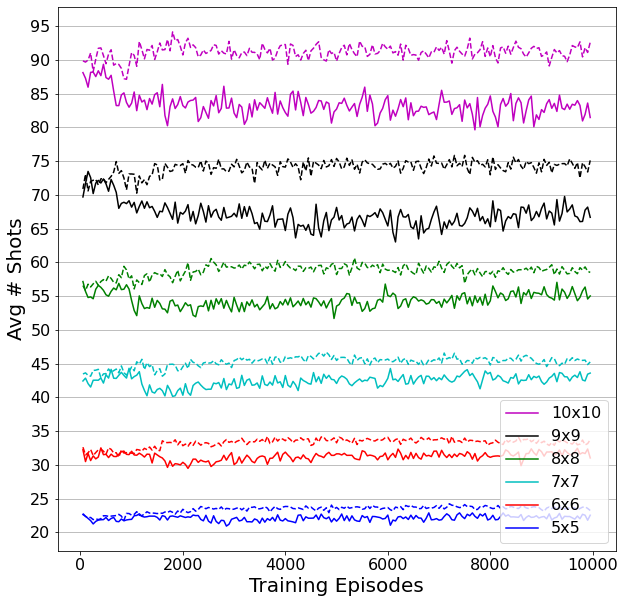

In [ ]:
# this cell creates a graph comparing the performance of deep-q and canon-deep-q over the course 
# of training

idx = [50 * i for i in range(1, len(canon_file_data[5]['reward_hist']) + 1)]

canon_avg_shots = {'{0}x{0}'.format(board_size): canon_file_data[board_size]['avg_shot_hist'] for board_size in range(5, 11)}
non_canon_avg_shots = {'{0}x{0}'.format(board_size): non_canon_file_data[board_size]['avg_shot_hist'] for board_size in range(5, 11)}

canon_avg_shots_df = pd.DataFrame(canon_avg_shots, index=idx)
non_canon_avg_shots_df = pd.DataFrame(non_canon_avg_shots, index=idx)

canon_reward = {'{0}x{0}'.format(board_size): canon_file_data[board_size]['reward_hist'] for board_size in range(5, 11)}
non_canon_reward = {'{0}x{0}'.format(board_size): non_canon_file_data[board_size]['reward_hist'] for board_size in range(5, 11)}

canon_reward_df = pd.DataFrame(canon_reward, index=idx)
non_canon_reward_df = pd.DataFrame(non_canon_reward, index=idx)

colors = ['b', 'r', 'c', 'g', 'k', 'm']
axis = canon_avg_shots_df.plot(figsize=(10,10), yticks=[i*5 for i in range(4, 20)], ylabel='Avg # Shots', 
                               xlabel='Training Episodes', fontsize=16, color=colors)
handles, labels = axis.get_legend_handles_labels()
styles = ['--', '--', '--', '--', '--', '--']
non_canon_avg_shots_df.plot(ax=axis, style=styles, color=colors)

axis.grid(axis='y')
axis.xaxis.label.set_size(20)
axis.yaxis.label.set_size(20)
axis.legend(handles[::-1], labels[::-1], fontsize=16, loc='lower right')

#axis = canon_reward_df.plot(figsize=(10,10))

In [ ]:
# this is the cell we used to train the deep q agent on various board sizes
# note that we finished the training on our personal machiens because google
# colab seems to time out before 10000 episodes can be completed when training
# on board sizes over 7x7

import os
os.chdir('/content/drive/MyDrive/574_models')
print(os.getcwd())

params = DQN_canon.DEFAULT_PARAMS.copy()
params['num_episodes'] = 10000

ships = {3:3}

for board_size in range(9, 11):
    DQN_canon.train_q_agent(board_dimension=board_size, params=params, ships=ships, use_canon=False)
    #DQN_canon.train_q_agent(board_dimension=board_size, params=params, ships=ships, use_canon=True)
os.chdir('/content/drive/MyDrive/574_models/standard_ships')
print(os.getcwd())
DQN_canon.train_q_agent(board_dimension=10, params=params, use_canon=False)
#DQN_canon.train_q_agent(board_dimension=10, params=params, use_canon=True)


/content/drive/MyDrive/574_models
EPISODE NUM: 10, avg # of shots (last 100 games) 72.7 			 epsilon: 0.9994


KeyboardInterrupt: ignored

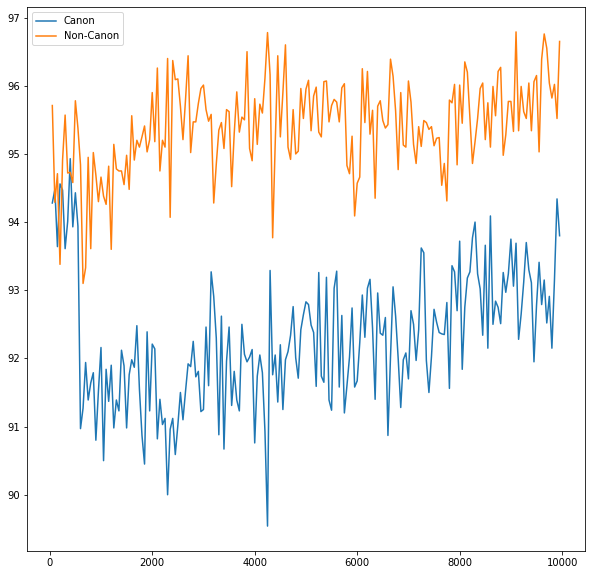

In [ ]:
# comparison of training rate between canon and non canon deep q on 10x10 with standard ships

with open('/content/drive/MyDrive/574_models/standard_ships/10x10_hidden512_canon_log.json'.format(board_size)) as file:
  canon_file_data = eval(file.read())
with open('/content/drive/MyDrive/574_models/standard_ships/10x10_hidden512_log.json'.format(board_size)) as file:
  non_canon_file_data = eval(file.read())

idx = [50 * i for i in range(1, len(canon_file_data['reward_hist']) + 1)]

canon_avg_shots = canon_file_data['avg_shot_hist']
non_canon_avg_shots = non_canon_file_data['avg_shot_hist']

avg_shots_df = pd.DataFrame({'Canon': canon_avg_shots, 'Non-Canon': non_canon_avg_shots}, index=idx)

#canon_reward = {'{0}x{0}'.format(board_size): canon_file_data[board_size]['reward_hist'] for board_size in range(5, 11)}
#non_canon_reward = {'{0}x{0}'.format(board_size): non_canon_file_data[board_size]['reward_hist'] for board_size in range(5, 11)}

#canon_reward_df = pd.DataFrame(canon_reward, index=idx)
#non_canon_reward_df = pd.DataFrame(non_canon_reward, index=idx)

axis = avg_shots_df.plot(figsize=(10,10))
#axis = non_canon_avg_shots_df.plot(figsize=(10,10))
#axis = canon_reward_df.plot(figsize=(10,10))
